Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [1]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import trange


## The *Nim* and *Nimply* classes

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [4]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [5]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [6]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [7]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim, func = nim_sum) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = func(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [8]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)
INFO:root:status: <1 3 5 7 5>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=3)
INFO:root:status: <1 3 5 4 5>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=2)
INFO:root:status: <1 1 5 4 5>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 0 5 4 5>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 0 2 4 5>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 2 4 5>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 0 2 4 3>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <0 0 0 4 3>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 0 0 4 2>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=3)
INFO:root:status: <0 0 0 1 2>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 0

## Rule-based Agent
Our `expert` system behaves in the following way

1. If there is a move that leaves only one single match remaining, it picks that move
2. Otherwise, looks for a move that sets the nim sum to 0
3. If no moves were found in steps 1 and 2, picks a random move

In [9]:
def expert(state: Nim) -> Nimply:
    analysis = analize(state, lambda s: sum(s.rows))
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, sum in analysis["possible_moves"].items() if sum == 1]  # first step: select a move that leaves only one match (winning move)
    if not spicy_moves:                                                                 # second step: select a move that sets the nim sum to 0
        analysis = analize(state)
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:                                                                 # third step: select a random move
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Evolution Strategies

We will now try different evolution strategies using a very simple genome.

### Individual

- The `genotype` is a single floating point number that describes the probability of choosing the move with the smallest non-zero nim sum from a list of possible moves
- The `fitness` is measured as the number of wins in 100 matches against our `expert` system

In [10]:
class Individual:
    genotype:float  # a number between 0 and 1, it's the probability of choosing the move with the smallest non-zero nim sum at any given time
    fitness: int

    def __init__(self, genotype) -> None:
        self.genotype = genotype

    def __str__(self) -> str:
        return f"{self.genotype}: {self.fitness}"

    def phenotype(self, state: Nim) -> Nimply:
        analysis = analize(state)
        spicy_moves = [(ply, ns) for ply, ns in analysis["possible_moves"].items() if ns != 0]
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
            return random.choice(spicy_moves)
        if random.random() < self.genotype: # choose the move with the smallest non-zero nim sum
            return min(spicy_moves, key = lambda i: i[1])[0]
        return random.choice(spicy_moves)[0]

In [11]:
def game(player1, player2=pure_random) -> (bool, int):  # plays a game between two different agents, defined as player1 and player2
    nim = Nim(5)
    strategy = (player1, player2)
    player = random.choice((0,1))  # randomly select starting player
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = not player
    return not player  # returns the losing player (1 if the winner is 0 and viceversa) and the duration of the game

In [12]:
def fitness(individual:Individual):  # the fitness is calculated as the winrate and the average number of moves calculated over 100 games
    winrate = 0
    for _ in range(100):
        player2 = expert
        won= game(individual.phenotype, player2)
        winrate += won
    return winrate

In [13]:
ind = Individual(random.random())

ind.fitness = fitness(ind)
print(ind)

0.7262132762092508: 4


In [14]:
def graph(individuals):
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Fitness and genotype at different generations')
    axs[0].plot(range(len(individuals)), [individual.fitness for individual in individuals])
    axs[1].plot(range(len(individuals)), [individual.genotype for individual in individuals])
    axs[0].set_ylabel("Fitness")
    axs[1].set_ylabel("Genotype")
    axs[1].set_xlabel("Generation")
    fig.show()

In [15]:
POPULATION_SIZE = 30
OFFSPRING_SIZE = 10
PARENTS_PER_CHILD = 2
TOUR_SIZE = 2
MUTATION_CHANCE = 0.05
SIGMA = 0.2
TOTAL_GENERATIONS = 100

In [16]:
def mutate(ind: Individual):
    return Individual(np.clip(np.random.normal(ind.genotype, SIGMA), 0, 1))

In [17]:
def xover(individuals):
    return Individual(np.average([i.genotype for i in individuals]))

In [18]:
def tour(individuals):
    tournament = [random.choice(individuals) for _ in range(TOUR_SIZE)]
    champion = max(tournament, key=lambda i: i.fitness)
    return champion

In [19]:
# initialize the population
def init_pop():
    population = [Individual(random.random()) for _ in range(POPULATION_SIZE)]
    for p in population:
        p.fitness = fitness(p)
    return population


population = init_pop()

## ($\mu$ + $\lambda$) ES

At each generation, we select the top individuals from both the current `population` and their `offspring`

100%|██████████| 100/100 [11:15<00:00,  6.76s/it]

0.021053573319565602: 63



C:\Users\Chare\AppData\Local\Temp\ipykernel_6728\1998303457.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


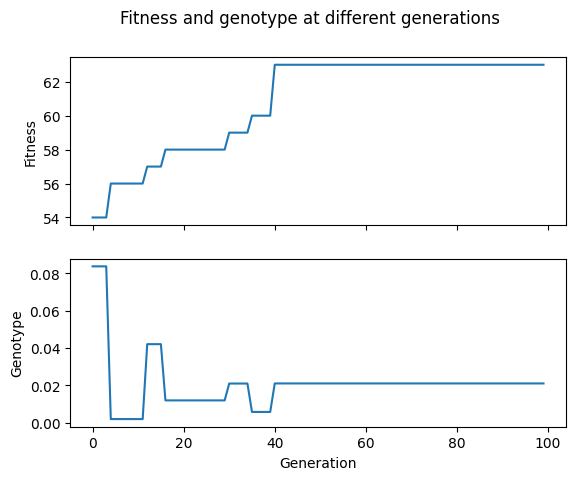

In [20]:
best = list()  # contains the best individual for each population, for graphing purposes

for generation in trange(TOTAL_GENERATIONS):
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_CHANCE: # mutate
            parent = tour(population)
            child = mutate(parent)
        else:
            parents = list()
            for _ in range(PARENTS_PER_CHILD):
                parents.append(tour(population))
            child = xover(parents)
        child.fitness = fitness(child)
        offspring.append(child)
    population.extend(offspring)
    population.sort(key = lambda i: i.fitness, reverse=True)
    population = population[: POPULATION_SIZE]
    best.append(population[0])
graph(best)
print(best[-1])


## ($\mu$, $\lambda$) ES

At each generation, we discard the `population` and perform the selection only on the `offspring`

In [21]:
POPULATION_SIZE = 10
OFFSPRING_SIZE = 30
PARENTS_PER_CHILD = 2
TOUR_SIZE = 2
MUTATION_CHANCE = 0.05
SIGMA = 0.2
TOTAL_GENERATIONS = 100

population = init_pop()

100%|██████████| 100/100 [38:05<00:00, 22.86s/it]
C:\Users\Chare\AppData\Local\Temp\ipykernel_6728\1998303457.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


7.813206396785706e-05: 59


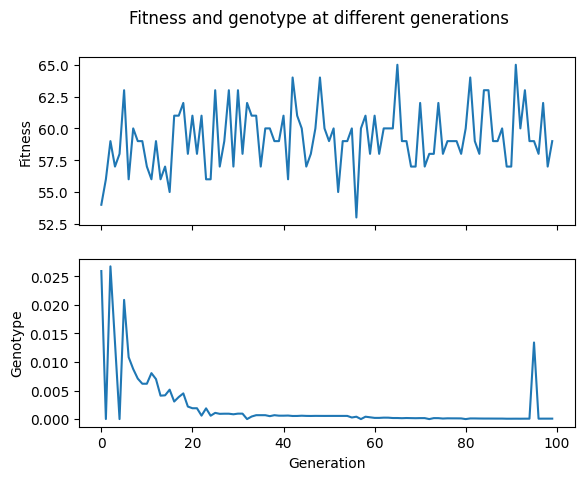

In [22]:
best = list()

for generation in trange(TOTAL_GENERATIONS):
    offspring = list()
    for _ in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_CHANCE: # mutate
            parent = tour(population)
            child = mutate(parent)
        else:
            parents = list()
            for _ in range(PARENTS_PER_CHILD):
                parents.append(tour(population))
            child = xover(parents)
        child.fitness = fitness(child)
        offspring.append(child)
    offspring.sort(key = lambda i: i.fitness, reverse=True)
    population = offspring[: POPULATION_SIZE]
    best.append(population[0])

graph(best)
print(best[-1])

### Observations
Both strategies yield a ~60% winrate against the `expert` system.
We can see that for this specific task, the comma strategy performs worse, and the fitness values fluctuate greatly.
This is probably because the `fitness` function is non-deterministic (e.g. its value changes at each evaluation).